<a href="https://colab.research.google.com/github/HMoreyP/Senado_Federal/blob/main/Senado_Federal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivos do Projeto**

1.   Analisar a quantidade de senadores por partido
2.   Entender como foi o comportamento da quantidade de senadores por partido
em cada legislatura
3.   Maior orçamento significa mais senadores no partido?
4.   Algum boxplot


#**Começo**

Precisamos fazer alguns imports que serão usados futuramente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET

#**1. Analisar a quantidade de senadores por partido**

Nesta seção vou selecionar alguns dados importantes para tratar não somente o primeiro objetivo mas também o segundo.

Aqui uso uma função que busca na API o ID, nome e partido de cada senador de uma legislatura específica.

A ideia é enxergar quantos senadores por partido entraram em exercício nas últimas cinco legislaturas, ou seja, de 2007 até 2027.

In [2]:
# Função para obter senadores de uma legislatura específica
def obter_senadores_por_legislatura(legislatura):

  # URL base da API do Senado para receber lista de senadores que exerceram alguma atividade em certa legislatura
  URL_BASE = "https://legis.senado.leg.br/dadosabertos/senador/lista/legislatura/"

  # Definir headers para evitar bloqueios
  HEADERS = {
    "User-Agent": "Mozilla/5.0"
  }

  params = {
    "exercicio": "S",  # Apenas senadores que exerceram o mandato
    "participacao": "T"  # Apenas titulares
  }

  url = f"{URL_BASE}{legislatura}"

  # Fazendo uma requisição get passando o que foi definido acima
  response = requests.get(url, headers=HEADERS, params=params)
  # Lança erro se a requisição falhar
  response.raise_for_status()

  # Parseando XML
  root = ET.fromstring(response.content)

  lista_de_senadores = []

  # Percorre os senadores da legislatura
  # Procura por todos os Parlamentar abaixo do nó atual
  for parlamentar in root.findall(".//Parlamentar"):

    identificacao = parlamentar.find("IdentificacaoParlamentar")

    if identificacao is not None:
      # Adiciona um dicionário com informações do senador na lista de senadores
      lista_de_senadores.append({
        "Legislatura": legislatura,
        "ID": identificacao.findtext("CodigoParlamentar"),
        "Nome": identificacao.findtext("NomeParlamentar"),
        "Partido": identificacao.findtext("SiglaPartidoParlamentar")
        })

  df = pd.DataFrame(lista_de_senadores)

  # TRATAMENTO DOS DADOS!

  # Substitui valores NaN pela string "Sem Partido". Importante caso o partido do senador não foi informado pela API
  df["Partido"] = df["Partido"].fillna("Sem Partido")
  # Remove linhas duplicadas
  df = df.drop_duplicates()

  # Retorna DataFrame com os senadores e partidos
  return df

A legislatura atual é a 57 e quero estudar ela, a 56, 55, 54 e 53.
Para isso definimos algumas variáveis.

In [3]:
# Criar DataFrame para armazenar todas as legislaturas
df_partidos_legislaturas = pd.DataFrame()

# Definindo o número da legislatura recente (57) e quantas queremos analisar
legislatura_atual = 57  # Legislatura 2023-2027
num_legislaturas_analisadas = 5     # Últimas 5 legislaturas

In [4]:
# Aqui vamos percorrer todas as legislaturas a serem estudadas
for legislatura in range(legislatura_atual, legislatura_atual - num_legislaturas_analisadas, -1):

  # Chamando a função passando o número da legislatura e
  # recebendo um DataFrame com os senadores e partidos
  df_legislatura = obter_senadores_por_legislatura(legislatura)

  if not df_legislatura.empty: # caso o consumo da API tenha dado certo, ou seja, tenha elementos no df

    # Contando quantos senadores tem em cada Partido na legislatura em questão
    contagem_partidos = df_legislatura["Partido"].value_counts()

    # Criando um DataFrame para colocar a quantidade de senadores em cada partido
    df_contagem = pd.DataFrame(contagem_partidos)
    df_contagem.columns = [f"Legislatura {legislatura}"] # cada coluna recebe o número da legislatura

    # Juntando os dados da legislatura em questão no DataFrame com os valores senadores/partido
    df_partidos_legislaturas = pd.concat([df_partidos_legislaturas, df_contagem], axis=1)

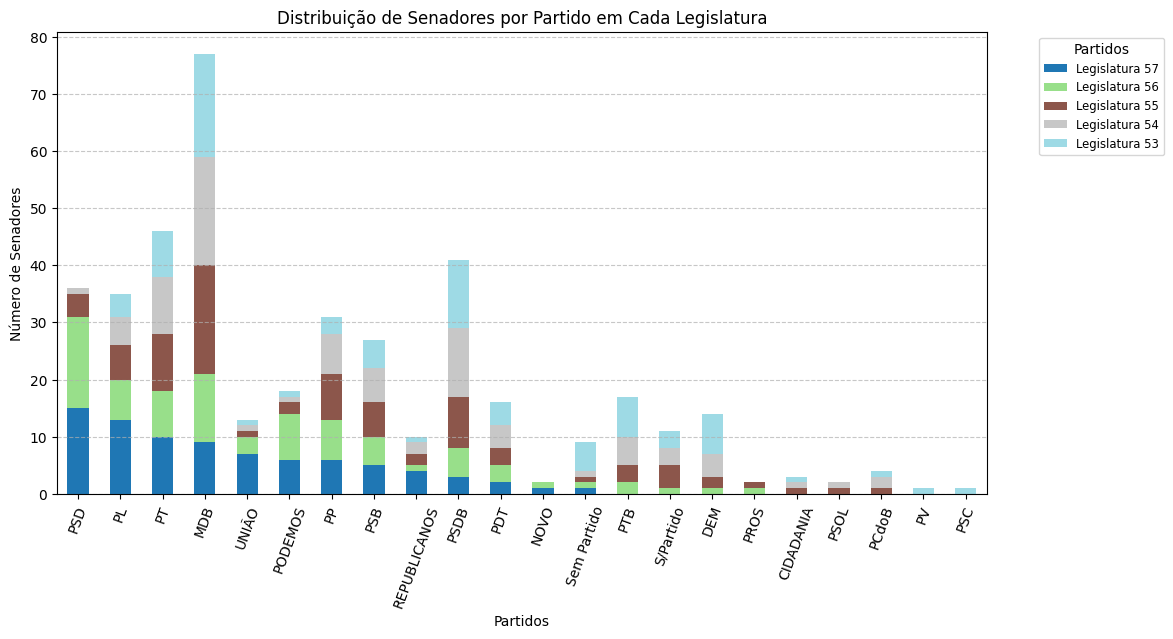

In [5]:
# Criar Gráfico de Barras Empilhadas
df_partidos_legislaturas.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

# Rotulando os eixos e dando título para o gráfico
plt.xlabel("Partidos")
plt.ylabel("Número de Senadores")
plt.title("Distribuição de Senadores por Partido em Cada Legislatura")

# Rotação dos Partidos para leitura melhor
plt.xticks(rotation=70)

# Adicionando legenda
plt.legend(title="Partidos", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
# Adicionando grid
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

O gráfico apresenta a distribuição do número de senadores por partido ao longo de cinco legislaturas (da 53ª à 57ª).

Cada barra representa um partido, cada cor representa uma legislatura e o tamanho de cada cor em cada barra é como se fosse a quantidade de senadores na legislatura em questão.

Olhando o gráfico, podemos inferir algumas informações.


1.**MDB** é historicamente dominante, mas perdeu força


*   O **MDB** sempre teve um alto número de senadores mas sua participação tem diminuido ao longo das últimas legislaturas. Pode ser que o partido esteja perdendo influência no Senado.

2.**PSD** e **PL** estão crescendo

*   Olhando para as legislaturas mais recentes, pricipalmente a (57), podemos notar que o **PSD** e o **PL** estão crescendo. Talvez indique que esses partidos estão conseguindo atrair mais senadores e podem estar se fortalecendo politicamente.


3.O **PSDB** sofreu uma grande queda

*   O **PSDB**, que já foi um partido com alta influência no Senado, aparece com um número reduzido de senadores nas últimas legislaturas. Isso pode refletiir na perda de representatividade do partido no Senado.


# **Conclusão**

O gráfico mostra uma clara mudança da política no Senado, com partidos que possuiam grande número de senadores, como **MDB** e **PSDB**, perdendo força, enquanto outros ppartidos como **PSD** e **PL** vêm ganhando espaço.

Podemos pensar que essa mudança pode estar ligada a fatores como **mudanças ideológicas** e/ou **desempenho eleitoral**.

#**2. Entender como foi o comportamento da quantidade de senadores por partido em cada legislatura**

Nesta seção vou usar dados já coletados anteriormente mas agora a ideia é tentar visualizar a evolução do número de senadores de cada partido ao longo das legislaturas analisadas.

Para isso, será plotado um gráfico temporal de linha e então será tirado algumas conclusões dele.

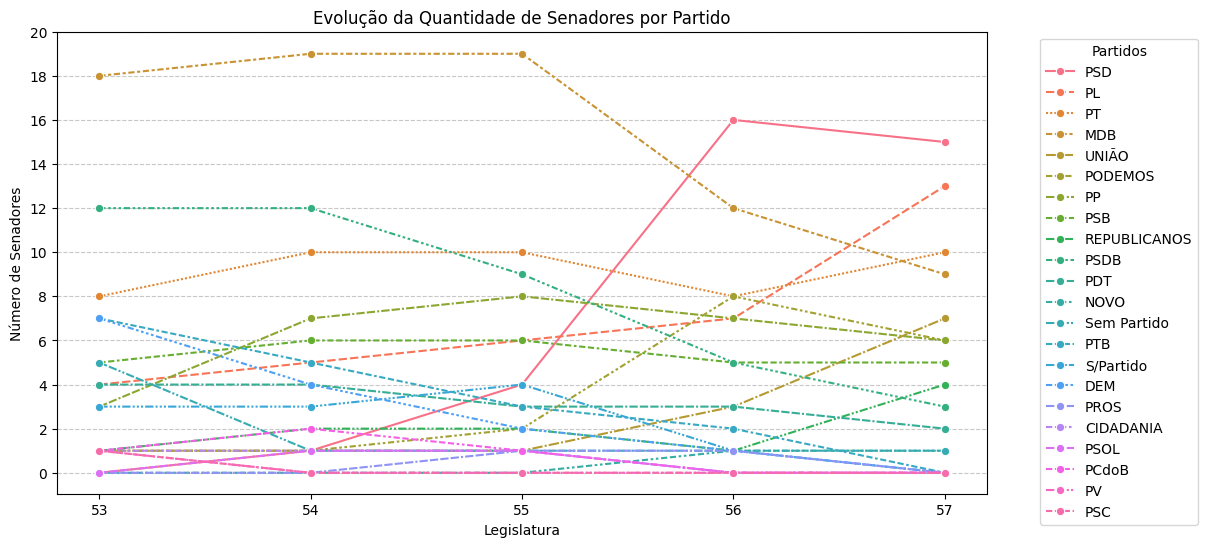

In [6]:
# Verificando se conseguimos consumir corretamente a API
if df_partidos_legislaturas.empty:
  print("Nenhum dado encontrado após filtragem.")
else:
  # Estamos transpondo o DataFrame porque a ideia é que a legislatura seja a variável temporal
  df_partidos_legislaturas = df_partidos_legislaturas.T

  # Aqui apenas estamos tratando os dados ausentes (NaN)
  df_partidos_legislaturas = df_partidos_legislaturas.fillna(0)

  # Para o eixo x não ficar escrito "Legistalura X" onde X = {57, 56, 55, 54, 53}
  # Estamos extraindo apenas o número da string
  df_partidos_legislaturas.index = df_partidos_legislaturas.index.str.extract(r'(\d+)')[0].astype(int)

  # Apenas definindo tamanho do gráfico e usando Seaborn para criar o gráfico
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=df_partidos_legislaturas, marker="o", dashes=True)

  # Rotulando os eixos e dando título para o gráfico  plt.xlabel("Legislatura")
  plt.xlabel("Legislatura")
  plt.ylabel("Número de Senadores")
  plt.title("Evolução da Quantidade de Senadores por Partido")

  # Ajustar os valores do eixo X para números inteiros e bem espaçados
  x_ticks = np.arange(df_partidos_legislaturas.index.min(), df_partidos_legislaturas.index.max() + 1, 1)
  plt.xticks(x_ticks)

  # Pegando o maior valor de cada Partido
  y_max = df_partidos_legislaturas.max()
  # Pegando o maior valor entre todos os Partidos
  y_max = y_max.max()
  # Define passos de 2 para o eixo Y
  y_ticks = np.arange(0, y_max + 2, 2)
  plt.yticks(y_ticks)

  # Adicionando legenda
  plt.legend(title="Partidos", bbox_to_anchor=(1.05, 1), loc='upper left')
  # Adicionando griid
  plt.grid(axis="y", linestyle="--", alpha=0.7)

  plt.show()

O gráfico representa a evolução do número de senadores por partido ao longo das legislaturas 53, 54, 55, 56 e 57. Cada linha corresponde a um partido político e mostra como a quantidade de senadores variou ao longo do tempo.


**1.   Crescimento do PSD e PL**


*   O **PSD** representado pela linha rosa contínua, teve um crescimento expressivo na 56ª legislatura, mas depois apresentou uma pequena queda na 57ª. O **PL**, representado por uma linha alaranjada e tracejada, também demonstra uma trajetória crescente. Essa leitura pode indicar uma preferência dos eleitores.

**2.   Declínio do MDB**

*   O **MDB**, que historicamente teve forte presença no Senado, mostra uma grande queda após a 56ª legislatura. Isso pode refletir numa perda de influência no Senado.

**3.   Estabilidade de Alguns Partidos**

*   O **PT**, por exemplo, sugere que mantém um eleitorado fiel e uma presença constante no Senado, já que o número de senadores se manteve quase o mesmo durante as legislaturas estudadas.

**4.   Aparição e Desaparecimento de Partidos**

*   Alguns partidos com menos senadores que aparecem em algumas legislaturas e desaparecem nas seguintes pode indicar que ouve uma junção com outro partido ou então uma mudança de nome.